## Оценка тональности отзыва на отель

Перед нами выборка с 20491 элементом. Проанализируем и построим классифкатор, который будет определять рейтинг отеля по отзыву, который о нем оставили.

* **Review** — отзыв на отель
* **Rating** — оценка (количество звезд от 0 до 5)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [4]:
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


### Визуальный анализ данных

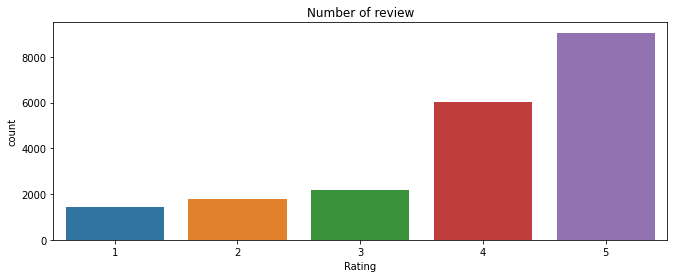

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 4))
sns.countplot(data['Rating']);
ax.set_title('Number of review');

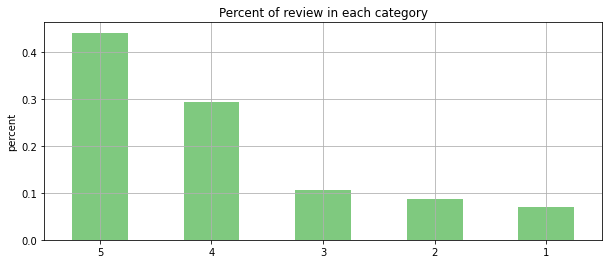

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
data['Rating'].value_counts(normalize=True).plot(kind='bar', rot=0, 
                                                             colormap='Accent', grid=True,
                                                             ylabel='percent',
                                                             title='Percent of review in each category');

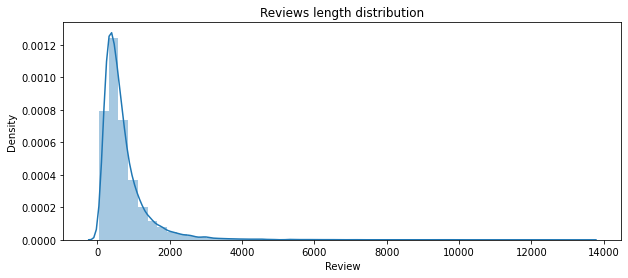

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.distplot(data['Review'].str.len());
ax.set_title('Reviews length distribution');

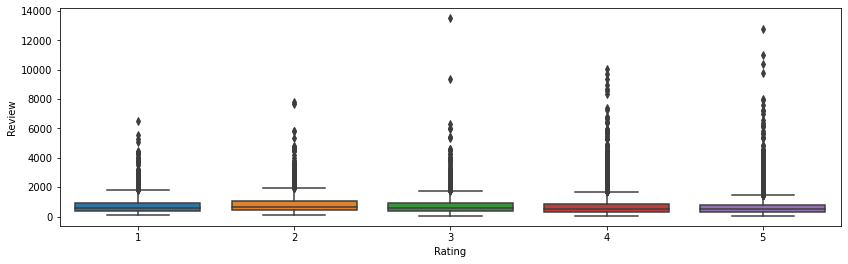

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))
sns.boxplot(x=data['Rating'], y=data['Review'].str.len());

In [10]:
data['Review'].str.len().describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Review, dtype: float64

In [11]:
data_more10 = data[data['Review'].str.len() > 10000]
len(data_more10)

5

In [6]:
quantile_95 = data['Review'].str.len().quantile(0.95)
data_95 = data[data['Review'].str.len() < quantile_95]

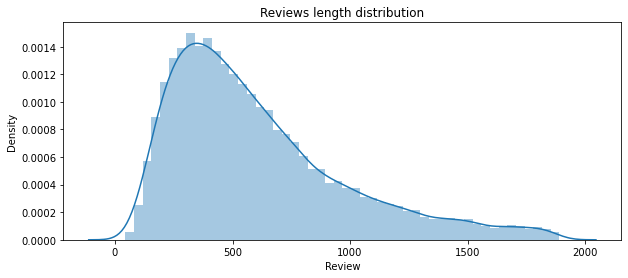

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
sns.distplot(data_95['Review'].str.len());
ax.set_title('Reviews length distribution');

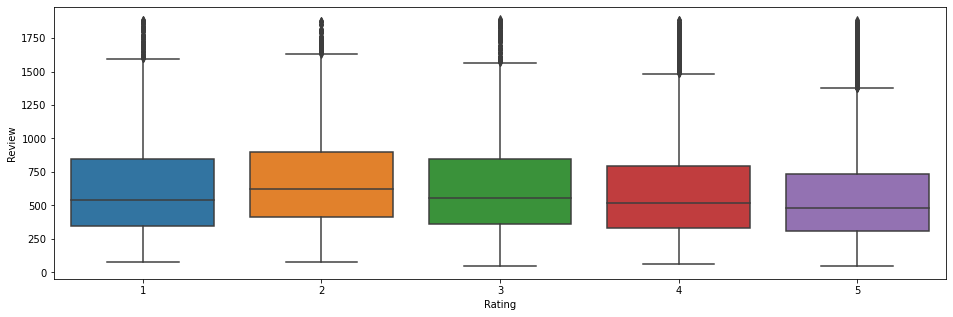

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
sns.boxplot(x=data_95['Rating'], y=data_95['Review'].str.len());

Из визуального анализа мы видим, что сильных аномалий в распределении признака нет. Положительных отзывов больше, чем негативных. Большинство отзывов небольшого размера, и преимущественно негативные отзывы длиннее.

Выделим отдельный признак **Tone** — определим, что отзыв будет считаться положительным, если его рейтинг будет больше 3, все остальные считаем негативными.

In [15]:
def tone(score):
    if score > 3:
        return 1
    else:
        return 0

In [16]:
data['Tone'] = data['Rating'].apply(tone)

In [17]:
data.head()

,Review,Rating,Tone
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


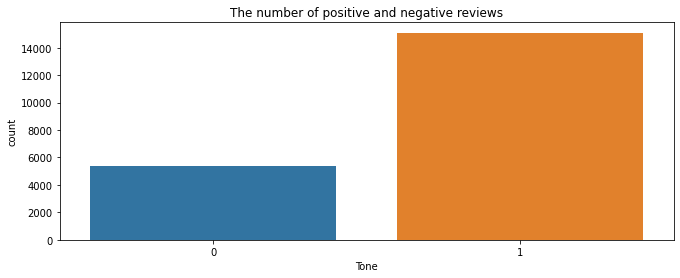

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 4))
sns.countplot(data['Tone']);
ax.set_title('The number of positive and negative reviews');

Положительных отзывов почти в 2 раза больше, но попробуем для начала построить модель без применения балансировки классов.

### Очистка и подготовка текста

#### Удаление символов

In [19]:
data.loc[:10]['Review']

0     nice hotel expensive parking got good deal sta...
1     ok nothing special charge diamond member hilto...
2     nice rooms not 4* experience hotel monaco seat...
3     unique, great stay, wonderful time hotel monac...
4     great stay great stay, went seahawk game aweso...
5     love monaco staff husband stayed hotel crazy w...
6     cozy stay rainy city, husband spent 7 nights m...
7     excellent staff, housekeeping quality hotel ch...
8     hotel stayed hotel monaco cruise, rooms genero...
9     excellent stayed hotel monaco past w/e delight...
10    poor value stayed monaco seattle july, nice ho...
Name: Review, dtype: object

Наша задача очистить отзывы от всех лишних слов и знаков препинания.

In [20]:
# удалим кавычки
data['Cleaned_review'] = data['Review'].str.replace('"', '')

In [21]:
# переведем весь текс в нижний регистр
data['Cleaned_review'] = data['Cleaned_review'].str.lower()

In [22]:
# удалим знаки препинания
punctuation_signs = list('?:!.,;')

for sign in punctuation_signs:
    data['Cleaned_review'] = data['Cleaned_review'].str.replace(sign, '')

In [23]:
# удалим окончания притяжательных местоимений
data['Cleaned_review'] = data['Cleaned_review'].str.replace("'s", "")

In [24]:
data.loc[:10]['Cleaned_review']

0     nice hotel expensive parking got good deal sta...
1     ok nothing special charge diamond member hilto...
2     nice rooms not 4* experience hotel monaco seat...
3     unique great stay wonderful time hotel monaco ...
4     great stay great stay went seahawk game awesom...
5     love monaco staff husband stayed hotel crazy w...
6     cozy stay rainy city husband spent 7 nights mo...
7     excellent staff housekeeping quality hotel cho...
8     hotel stayed hotel monaco cruise rooms generou...
9     excellent stayed hotel monaco past w/e delight...
10    poor value stayed monaco seattle july nice hot...
Name: Cleaned_review, dtype: object

#### Стемминг и лемматизация

In [25]:
# Загрузим punkt and wordnet из NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [26]:
wordnet_lemmatizer = WordNetLemmatizer()

In [27]:
nrows = len(data)
lemmatized_text_list = []

for row in range(0, nrows):
    lemmatized_list = []
    text = data.loc[row]['Cleaned_review']
    text_words = text.split(' ')

    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos='v'))
        
    lemmatized_text = ' '.join(lemmatized_list)
    
    lemmatized_text_list.append(lemmatized_text)

In [28]:
data['Cleaned_review'] = lemmatized_text_list

#### Стоп-слова

In [29]:
# Загрузим список стоп-слов
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stop_words = list(stopwords.words('english'))

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    data['Cleaned_review'] = data['Cleaned_review'].str.replace(regex_stopword, '')

In [31]:
data.loc[:10]['Cleaned_review']

0     nice hotel expensive park get good deal stay h...
1     ok nothing special charge diamond member hilto...
2     nice room  4* experience hotel monaco seattle ...
3     unique great stay wonderful time hotel monaco ...
4     great stay great stay go seahawk game awesome ...
5     love monaco staff husband stay hotel crazy wee...
6     cozy stay rainy city husband spend 7 nights mo...
7     excellent staff housekeep quality hotel chock ...
8     hotel stay hotel monaco cruise room generous d...
9     excellent stay hotel monaco past w/e delight r...
10    poor value stay monaco seattle july nice hotel...
Name: Cleaned_review, dtype: object

Мы подготовили тексты — удалили лишние знаки препинания, стоп-слова, применили стемминг и лемматизацию. Отзывы готовы к дальнейшей предобработке и классификации.

### Разделение данных

In [32]:
X = data['Cleaned_review']
y = data['Tone']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=2, shuffle=True, stratify=y)

In [34]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5,
                                                random_state=2, shuffle=True, stratify=y_test)

### Текстовое представление

In [35]:
# Parameter election
ngram_range = (1,3)
max_feat=10000

In [36]:
tfidf = TfidfVectorizer(ngram_range=ngram_range,
                        max_features=max_feat)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_valid = tfidf.transform(X_valid).toarray()
labels_valid = y_valid
print(features_valid.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(14343, 10000)
(3074, 10000)
(3074, 10000)


### Снижение размерности данных

Уменьшим количество признаков, применив метод главных компонент.

In [37]:
features = np.concatenate((features_train, features_valid, features_test), axis=0)
labels = np.concatenate((labels_train, labels_valid, labels_test), axis=0)

In [38]:
pca = PCA(0.9).fit(features)
print('We need %d components to explain 90%% of variance' 
      % pca.n_components_)

We need 4872 components to explain 90% of variance


In [39]:
pca = PCA(n_components=4900, svd_solver='randomized')
pca.fit(features_train)

PCA(copy=True, iterated_power='auto', n_components=4900, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

In [40]:
features_train_pca = pca.transform(features_train)
features_valid_pca = pca.transform(features_valid)
features_test_pca = pca.transform(features_test)

### Обучение модели

#### Logistic Regression

In [41]:
lr = LogisticRegression(solver='liblinear', random_state=2, n_jobs=-1)
lr.fit(features_train_pca, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=2,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [42]:
print("The training accuracy : {:.2f} %".format(accuracy_score(lr.predict(features_train_pca), labels_train)*100))
print("The validation accuracy  : {:.2f} %".format(accuracy_score(lr.predict(features_valid_pca), labels_valid)*100))

The training accuracy : 92.43 %
The validation accuracy  : 90.37 %


In [43]:
train_acc_lr = accuracy_score(lr.predict(features_train_pca), labels_train) * 100
valid_acc_lr = accuracy_score(lr.predict(features_valid_pca), labels_valid) * 100

In [56]:
data_models = pd.DataFrame(columns = ['Training Set Accuracy', 'Validation Set Accuracy'])
data_models.loc['Logistic Regression'] = [train_acc_lr, valid_acc_lr]

#### XGBoost

In [45]:
xgb = XGBClassifier(random_state=2)
xgb.fit(features_train_pca, labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
print("The training accuracy : {:.2f} %".format(accuracy_score(xgb.predict(features_train_pca), labels_train)*100))
print("The validation accuracy  : {:.2f} %".format(accuracy_score(xgb.predict(features_valid_pca), labels_valid)*100))

The training accuracy : 88.87 %
The validation accuracy  : 87.67 %


In [47]:
train_acc_xgb = accuracy_score(xgb.predict(features_train_pca), labels_train) * 100
valid_acc_xgb = accuracy_score(xgb.predict(features_valid_pca), labels_valid) * 100

In [66]:
data_models.loc['XGBoost'] = [train_acc_xgb, valid_acc_xgb]

#### Random Forest Classifier

In [49]:
rfc= RandomForestClassifier(random_state=2,n_jobs=-1)
rfc.fit(features_train_pca, labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [50]:
print("The training accuracy : {:.2f} %".format(accuracy_score(rfc.predict(features_train_pca), labels_train)*100))
print("The validation accuracy  : {:.2f} %".format(accuracy_score(rfc.predict(features_valid_pca), labels_valid)*100))

The training accuracy : 100.00 %
The validation accuracy  : 74.40 %


In [51]:
train_acc_rfc = accuracy_score(rfc.predict(features_train_pca), labels_train) * 100
valid_acc_rfc = accuracy_score(rfc.predict(features_valid_pca), labels_valid) * 100

In [67]:
data_models.loc['Random Forest Classifier'] = [train_acc_rfc, valid_acc_rfc]

#### Multinomial Naive Bayes

In [59]:
from sklearn.naive_bayes import MultinomialNB

In [60]:
mnb = MultinomialNB()
mnb.fit(features_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [62]:
print("The training accuracy is : {:.2f} %".format(accuracy_score(mnb.predict(features_train), labels_train)*100))
print("The validation accuracy is : {:.2f} %".format(accuracy_score(mnb.predict(features_valid), labels_valid)*100))

The training accuracy is : 88.74 %
The validation accuracy is : 87.38 %


In [63]:
train_acc_mnb = accuracy_score(mnb.predict(features_train), labels_train) * 100
valid_acc_mnb = accuracy_score(mnb.predict(features_valid), labels_valid) * 100

In [64]:
data_models.loc['Multinomial Naive Bayes'] = [train_acc_mnb, valid_acc_mnb]

In [68]:
data_models.head()

,Training Set Accuracy,Validation Set Accuracy
Logistic Regression,92.428362,90.370852
Multinomial Naive Bayes,88.740152,87.378009
XGBoost,88.865649,87.670787
Random Forest Classifier,100.000000,74.398178


Опираясь на точность, остановим свой выбор на модели логистической регрессии. Проверим, какие будут результаты на тестовой выборке.

In [70]:
print("The test accuracy is : {:.2f} %".format(accuracy_score(lr.predict(features_test_pca), labels_test)*100))

The test accuracy is : 89.23 %
